In [1]:
# %% imports
import os, re, glob, json
import numpy as np
import pandas as pd

# будем стараться работать и с librosa, и с torchaudio
try:
    import librosa
except Exception:
    librosa = None

try:
    import soundfile as sf
except Exception:
    sf = None

# %% мел-спектрограмма (с запасным планом)
def load_audio(path, sr=48000):
    """Загружает аудио в моно, sr Гц."""
    if librosa is not None:
        y, _sr = librosa.load(path, sr=sr, mono=True)
        return y, sr
    if sf is not None:
        y, file_sr = sf.read(path, dtype="float32", always_2d=False)
        if y.ndim > 1:  # stereo -> mono
            y = y.mean(axis=1)
        # простая ресемплинг-замена при отсутствии librosa (не идеально, но рабоче)
        if file_sr != sr:
            # на всякий случай сделаем грубый ресемпл через интерполяцию
            x_old = np.linspace(0, 1, num=len(y), endpoint=False)
            x_new = np.linspace(0, 1, num=int(len(y) * sr / file_sr), endpoint=False)
            y = np.interp(x_new, x_old, y).astype(np.float32)
        return y, sr
    raise RuntimeError("Нужен хотя бы один из пакетов: librosa или soundfile")

def mel_spectrogram(y, sr, n_fft=1024, hop_length=256, n_mels=128, fmin=20, fmax=None):
    if librosa is None:
        # простая STFT + мел-фильтры вручную без librosa — опустим детали ради компактности
        # лучше установить librosa: pip install librosa
        raise RuntimeError("Для mel-спектрограммы лучше установить librosa: pip install librosa")
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax
    )
    # мощность -> dB стабилизация (можно оставить как есть — выбор ваш)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

def l1_on_mels(path_a, path_b, sr=22050, **mel_kwargs):
    y1, _ = load_audio(path_a, sr=sr)
    y2, _ = load_audio(path_b, sr=sr)
    M1 = mel_spectrogram(y1, sr, **mel_kwargs)
    M2 = mel_spectrogram(y2, sr, **mel_kwargs)
    # выровняем по времени (колонкам)
    T = min(M1.shape[1], M2.shape[1])
    M1 = M1[:, :T]
    M2 = M2[:, :T]
    return np.mean(np.abs(M1 - M2))

# %% эвристика: выбрать src и tgt файл в папке
SRC_HINTS = re.compile(r"_0\.wav$", re.I)
TGT_HINTS = re.compile(r"_1\.wav$", re.I)

def pick_pair_in_folder(folder):
    """Ищет 2 аудиофайла: сначала по подсказкам в имени, иначе — первые два по алфавиту."""
    exts = ("*.wav", "*.flac", "*.mp3", "*.ogg")
    files = []
    for ext in exts:
        files += glob.glob(os.path.join(folder, ext))
    files = sorted(files)
    if len(files) < 2:
        return None, None

    # 1) хинты
    src_candidates = [f for f in files if SRC_HINTS.search(os.path.basename(f))]
    tgt_candidates = [f for f in files if TGT_HINTS.search(os.path.basename(f))]
    if src_candidates and tgt_candidates:
        # берём по одному
        return src_candidates[0], tgt_candidates[0]

    # 2) если только один с хинтом — разделим на src и всё остальное
    if src_candidates and len(files) >= 2:
        rest = [f for f in files if f != src_candidates[0]]
        return src_candidates[0], rest[0]
    if tgt_candidates and len(files) >= 2:
        rest = [f for f in files if f != tgt_candidates[0]]
        return rest[0], tgt_candidates[0]

    # 3) fallback — первые два файла
    return files[0], files[1]

# %% обойти папку outputs и собрать метрики
def collect_l1_table(outputs_root="outputs", sr=22050, mel_kwargs=None):
    mel_kwargs = mel_kwargs or dict(n_fft=1024, hop_length=256, n_mels=128, fmin=20, fmax=None)
    rows = []
    # ожидаем структуру: outputs/<exp_name>/<params_identifier>/
    exp_names = sorted([d for d in os.listdir(outputs_root) if os.path.isdir(os.path.join(outputs_root, d))])
    for exp in exp_names:
        exp_path = os.path.join(outputs_root, exp)
        param_dirs = sorted([d for d in os.listdir(exp_path) if os.path.isdir(os.path.join(exp_path, d))])
        for pid in param_dirs:
            folder = os.path.join(exp_path, pid)
            src, tgt = pick_pair_in_folder(folder)
            if not src or not tgt:
                print(f"[WARN] пропускаю (нет пары): {folder}")
                continue
            try:
                dist = l1_on_mels(src, tgt, sr=sr, **mel_kwargs)
            except Exception as e:
                print(f"[ERR] {folder}: {e}")
                continue
            rows.append({
                "exp_name": exp,
                "params_identifier": pid,
                "src_file": os.path.basename(src),
                "tgt_file": os.path.basename(tgt),
                "l1_mel": float(dist),
            })
    return pd.DataFrame(rows)

df = collect_l1_table("outputs")
df.head()


,exp_name,params_identifier,src_file,tgt_file,l1_mel
0,all_blocks,alt_rock,output_20250806005055_0.wav,output_20250806005055_1.wav,4.596523
1,all_blocks,dance_pop,output_20250806004904_0.wav,output_20250806004904_1.wav,5.555578
2,all_blocks,dark_cinematic,output_20250806004941_0.wav,output_20250806004941_1.wav,6.188282
3,all_blocks,dreamy_ambient,output_20250806004845_0.wav,output_20250806004845_1.wav,9.632608
4,all_blocks,electro_house,output_20250806004923_0.wav,output_20250806004923_1.wav,5.240098


In [2]:
# %% агрегация и ранжировка
if df.empty:
    print("Данных не найдено. Проверьте структуру outputs/<exp>/<id> и наличие аудио.")
else:
    # рейтинг по среднему L1 для каждого конфига слоёв (exp_name)
    rank = (
        df.groupby("exp_name")["l1_mel"]
          .agg(["mean", "median", "std", "count"])
          .sort_values("mean", ascending=True)
          .reset_index()
    )
    display(rank)


,exp_name,mean,median,std,count
0,all_blocks,5.854539,5.397838,1.632460,10
1,quarter_2_4,5.870905,4.997102,1.721411,10
2,first_half,5.967765,5.496737,1.986038,10
3,odd_blocks,6.111520,5.616270,1.563200,10
4,quarter_2,6.119724,5.600448,2.060768,10
5,quarter_2_3,6.178816,5.697168,2.049004,10
6,skip_three,6.255856,6.219865,1.884741,10
7,even_blocks,6.266922,5.829401,2.007001,10
8,sparse_middle,6.291954,6.358332,1.931246,10
9,second_half,6.443626,6.241450,1.716598,10


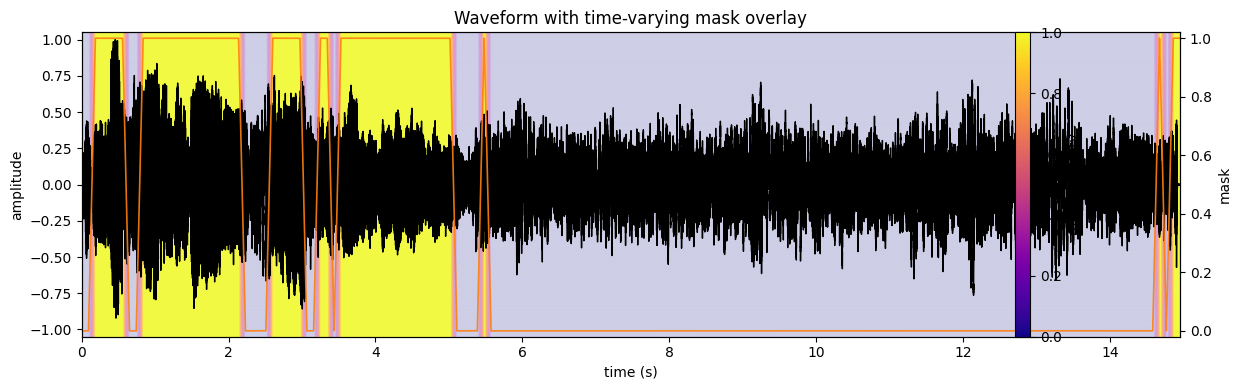

In [19]:
# Visualize a time-varying mask overlaid on a waveform, with colors.
# - If you set `audio_path` to an audio file, it will load and plot that.
# - Otherwise, it will generate a short synthetic demo waveform so you can see the overlay.
#
# You can tweak:
#   - colormap name (`cmap_name`)
#   - overlay alpha range (`overlay_alpha_min`, `overlay_alpha_max`)
#   - whether to also draw the mask as a line (`draw_mask_line`)

import numpy as np
import matplotlib.pyplot as plt

# ---- Input mask (your list) ----
l = [0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]

mask = np.asarray(l, dtype=float)
mask = np.clip(mask, 0.0, 1.0)

# ---- Audio source: set a path if you want to load real audio ----
audio_path = 'outputs/center_4_+sparse/psytrance/output_20250811003203_0.wav'  # e.g. "outputs/example.wav"

# Plot styling
cmap_name = "plasma"           # colormap for the overlay
overlay_alpha_min = 0.20       # minimum alpha of overlay
overlay_alpha_max = 0.85       # maximum alpha of overlay
draw_mask_line = True          # also draw mask as a line on top

# ---- Prepare waveform ----
sr = 48000
if audio_path is None:
    # Synthetic demo waveform (replace with your own audio if needed)
    duration = 15.0
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    # A simple synthetic mixture: two sines + amplitude modulation
    y = 0.6*np.sin(2*np.pi*220*t) + 0.4*np.sin(2*np.pi*440*t)
    y *= (0.5 + 0.5*np.sin(2*np.pi*0.5*t))  # slow AM for visual variety
else:
    try:
        import soundfile as sf
        y, file_sr = sf.read(audio_path, dtype="float32", always_2d=False)
        if y.ndim > 1:
            y = y.mean(axis=1)
        # resample if needed
        if file_sr != sr:
            x_old = np.linspace(0, 1, num=len(y), endpoint=False)
            x_new = np.linspace(0, 1, num=int(len(y) * sr / file_sr), endpoint=False)
            y = np.interp(x_new, x_old, y).astype(np.float32)
        duration = len(y) / sr
        t = np.linspace(0, duration, len(y), endpoint=False)
    except Exception as e:
        # fallback to synthetic if loading fails
        duration = 6.0
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        y = 0.6*np.sin(2*np.pi*220*t) + 0.4*np.sin(2*np.pi*440*t)
        y *= (0.5 + 0.5*np.sin(2*np.pi*0.5*t))

# Normalize waveform for plotting
if np.max(np.abs(y)) > 0:
    y_plot = y / np.max(np.abs(y))
else:
    y_plot = y

# ---- Resample mask to waveform length ----
mask_resampled = np.interp(
    np.linspace(0, 1, len(y_plot), endpoint=False),
    np.linspace(0, 1, len(mask), endpoint=False),
    mask
)

# ---- Build colored overlay with alpha varying by mask ----
# We'll render an image with shape (1, T) and map values to colors via colormap,
# and set alpha based on mask strength so it "lights up" where mask is high.
cmap = plt.get_cmap(cmap_name)
overlay_colors = cmap(mask_resampled)  # RGBA, last channel will be replaced by custom alpha
alpha = overlay_alpha_min + (overlay_alpha_max - overlay_alpha_min) * mask_resampled
overlay_colors[..., -1] = alpha

# For imshow we need a (H, W, 4) image. We'll use H=1 row and stretch over the axis extent.
overlay_img = overlay_colors[np.newaxis, :, :]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12, 4))

# Waveform
ax.plot(t, y_plot, linewidth=1.0, color="black", label="waveform")

# Colored overlay spanning the vertical axis
ax.imshow(
    overlay_img,
    aspect="auto",
    extent=[t[0], t[-1], -1.05, 1.05],
    origin="lower"
)

# Optional: mask line on a secondary y-axis (0..1)
if draw_mask_line:
    ax2 = ax.twinx()
    ax2.plot(t, mask_resampled, linewidth=1.2, color="tab:orange", alpha=0.9, label="mask")
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_ylabel("mask")

ax.set_xlim(t[0], t[-1])
ax.set_ylim(-1.05, 1.05)
ax.set_xlabel("time (s)")
ax.set_ylabel("amplitude")
ax.set_title("Waveform with time-varying mask overlay")

# Add a colorbar to show mapping
# We'll create a standalone colorbar referencing the same colormap.
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.02)
cbar.set_label("mask intensity")

plt.tight_layout()
plt.show()
